### В данном ноутбуке попробуем построить модель для классификации изображений с сайта https://quickdraw.withgoogle.com/. Данные взяты с формате .npy и представляют из себя 784 пикселя(Ниже примеры). Для моделирования будем использовать библиотеку tensorflow и keras, catboost, 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from os import walk
import re
from tqdm import tqdm
import uuid

In [2]:
df = pd.read_csv('F:\\doodles\\bucket_31.csv', dtype=dict(zip(range(784), [np.uint8]*784)))
df.drop(columns=['Unnamed: 0'], inplace= True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173405 entries, 0 to 173404
Columns: 785 entries, 0 to category
dtypes: int64(1), object(1), uint8(783)
memory usage: 132.1+ MB


In [4]:
df.groupby('category').count()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
category,,,,,,,,,,,,,,,,,,,,,
airplane,607,607,607,607,607,607,607,607,607,607,...,607,607,607,607,607,607,607,607,607,607
ambulance,592,592,592,592,592,592,592,592,592,592,...,592,592,592,592,592,592,592,592,592,592
angel,599,599,599,599,599,599,599,599,599,599,...,599,599,599,599,599,599,599,599,599,599
ant,499,499,499,499,499,499,499,499,499,499,...,499,499,499,499,499,499,499,499,499,499
anvil,505,505,505,505,505,505,505,505,505,505,...,505,505,505,505,505,505,505,505,505,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
windmill,483,483,483,483,483,483,483,483,483,483,...,483,483,483,483,483,483,483,483,483,483
wristwatch,651,651,651,651,651,651,651,651,651,651,...,651,651,651,651,651,651,651,651,651,651
yoga,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122,...,1122,1122,1122,1122,1122,1122,1122,1122,1122,1122


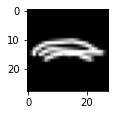

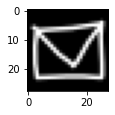

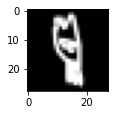

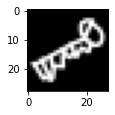

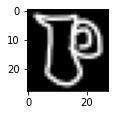

In [5]:
categories = []
for i in range(5):
    sample = df.sample(1)
    pixels = sample.drop(columns=['category']).values.reshape((28, 28))
    categories.append(sample['category'].values[0])
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [6]:
categories

['rainbow', 'envelope', 'goatee', 'key', 'mug']

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit_transform(df['category'])
df["category_enc"] = le.transform(df['category'])
y = df['category_enc']
to_drop = ['category', 'category_enc']
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=to_drop), y, test_size=0.3,random_state=42)

In [ ]:
from catboost import CatBoostClassifier

clf_cat = CatBoostClassifier(task_type='GPU', max_depth=5)
clf_cat.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report

y_pred = [*map(lambda x: np.argmax(x), pred)]
report = pd.DataFrame.from_dict(classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)).T
report

### Бустинг скорее всего не подойдет, слишком большой датасет и максимальную глубину получается выставить только на 6, думаю для 200+ классов этого маловато. Точность около 40%.

### Попробуем нейронные сети, говорят они хорошо подходят.

In [8]:
import tensorflow as tf
from tensorflow import keras

tf.config.experimental.set_memory_growth(tf.config.get_visible_devices('GPU')[0], True)
DROP_OUT = 4
KERNEL_SIZE = 3
CATEGORIES = len(df['category'].unique())
model = keras.Sequential([
    keras.layers.Reshape((-1,28,28,1)),
    keras.layers.experimental.preprocessing.Rescaling(scale=1./255.),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
        
    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Flatten(),

    keras.layers.Dense(CATEGORIES * 10, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Dense(CATEGORIES * 30, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Dense(CATEGORIES * 30, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Dense(CATEGORIES, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
try:
    file = 'F:\\doodles\\dump'
    model = keras.models.load_model(file)
    reports = []
except:
    print("Probably model wasn't saved yet")

In [10]:
from sklearn.metrics import classification_report
import gc
from PIL import Image

FLAT_SIZE = 28*28
RESIZED = 56*56*3
INT = np.uint8
FILEMANE_PATTERN = 'F:\\doodles\\bucket_{}.csv'
val_X_test = None
val_y_test = None

def free(to_erase):
    for obj in to_erase:
        obj = None
    gc.collect()
    
def load_val_data(encoder):
    df = pd.read_csv('F:\\doodles\\bucket_249.csv', dtype=get_dtypes())
    df.drop(columns=['Unnamed: 0'], inplace=True)
    df["category_enc"] = encoder.transform(df['category'])
    y = df['category_enc']
    to_drop = ['category', 'category_enc']
    return (df.drop(columns=to_drop), y)
    
def load_data(i, encoder, pattern ='F:\\doodles\\bucket_{}.csv', test_size = 0.2):
    df = pd.read_csv(pattern.format(str(i)), dtype=get_dtypes())
    df.drop(columns=['Unnamed: 0'], inplace= True)
    df["category_enc"] = encoder.transform(df['category'])
    y = df['category_enc']
    to_drop = ['category', 'category_enc']
    return train_test_split(df.drop(columns=to_drop), y, test_size=test_size)

def get_report(model, encoder):
    global val_X_test, val_y_test 
    if val_X_test is None or val_y_test is None:
        print("Loading val data...")
        val_X_test, val_y_test = load_val_data(le)
    pred = model.predict(val_X_test)
    y_pred = [*map(lambda x: np.argmax(x), pred)]
    return pd.DataFrame.from_dict(classification_report(val_y_test, y_pred, target_names=le.classes_, output_dict=True)).T

def get_weight(value, mean, max_weight):
    value = mean / value ** 7
    return 1 if value <=1 else max_weight if value >= max_weight else value

def get_weights(model, encoder, max_weight=5, metric='f1-score', report = None):
    if report is None:
        report = get_report(model, encoder)
    mean = report[metric].mean()
    return dict((class_, get_weight(report.loc[[class_]][metric][0], mean, max_weight)) for class_ in encoder.classes_)

def get_dtypes():
    return dict(zip(range(FLAT_SIZE), [INT]*FLAT_SIZE))

def rgb_and_resize(arr):
    img = arr.reshape((28, 28)).astype(INT)
    image = Image.fromarray(img).resize((56,56))
    image = image.convert('RGB')
    return np.array(image).astype(INT)

def markup(arr, category):
    return np.append(arr, np.array([[category] * arr.shape[0]]).T, axis=1)

def convert(df):
    converted_arrs = np.zeros((len(df), RESIZED), dtype = INT) 
    categories = np.array([None] * len(df))
    for i in range(len(df)):
        rgb = rgb_and_resize(df.loc[[i]].drop(columns=['category']).values)
        converted_arrs[i] = rgb.flatten()
        categories[i] = df.at[i,'category']
    result = pd.DataFrame(converted_arrs)
    result['category'] = categories
    return result
    
def load_converted(i, num_of_batches):
    df = pd.read_csv(FILEMANE_PATTERN.format(str(i)), dtype=get_dtypes())
    if num_of_batches > 1:
        for j in range(i+1, i+num_of_batches):
            df.append(pd.read_csv(FILEMANE_PATTERN.format(str(j)), dtype=get_dtypes()))
    df.drop(columns=['Unnamed: 0'], inplace=True)
    return convert(df)

def load_and_split(i, encoder, test_size = 0.2, num_of_batches=1):
    df = load_converted(i, num_of_batches)
    df["category_enc"] = encoder.transform(df['category'])
    y = df['category_enc']
    to_drop = ['category', 'category_enc']
    return train_test_split(df.drop(columns=to_drop), y, test_size=test_size)

def fit_in_loop(model, encoder,
                epochs=8, batch_size=250, 
                start=0, stop=249,
                save_interval=10, dump_file='F:\\doodles\\dump',
                need_report=True, need_save=True,
                fn_data_load=load_data):
    for i in tqdm(range(start, stop)):
        try:
            X_train, X_test, y_train, y_test = fn_data_load(i, encoder)
            model.fit(X_train, y_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             validation_data=(X_test, y_test))
        
            if need_save and i % save_interval == 0:
                model.save(dump_file)  
            
            free([X_train, X_test, y_train, y_test])
            
            if need_report:
                report = get_report(model, le)  
                reports.append(report)
                
        except KeyboardInterrupt:
            print("Stopped. Current bucket is {}".format(str(i)))
            break

In [11]:
fit_in_loop(model, le, start=201, epochs=1)

  0%|          | 0/48 [00:00<?, ?it/s]

555/555 [==============================] - 60s 92ms/step - loss: 1.1670 - accuracy: 0.7099 - val_loss: 0.9837 - val_accuracy: 0.7509
Loading val data...


  2%|▏         | 1/48 [01:40<1:18:30, 100.22s/it]

328/555 [================>.............] - ETA: 18s - loss: 1.1638 - accuracy: 0.7097

  2%|▏         | 1/48 [02:13<1:44:30, 133.42s/it]

Stopped. Current bucket is 202


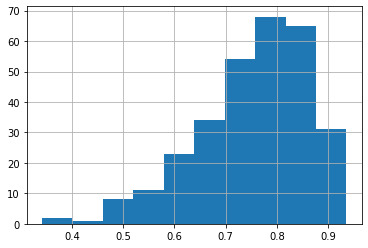

In [12]:
for report in reports:
    report['f1-score'].hist()
    plt.show()

In [13]:
reports[-1].describe()

,precision,recall,f1-score,support
count,297.000000,297.000000,297.000000,297.000000
mean,0.761636,0.750463,0.751288,1749.073237
std,0.114005,0.124778,0.108600,14138.324165
min,0.275893,0.323529,0.341436,0.751325
25%,0.699552,0.683778,0.689713,495.000000
50%,0.783307,0.773556,0.766486,526.000000
75%,0.840580,0.835907,0.830149,634.000000
max,0.978923,0.958580,0.936078,173158.000000


In [14]:
reports[-1][reports[-1]['f1-score'] > 0.9]

,precision,recall,f1-score,support
butterfly,0.939394,0.921444,0.930332,471.0
crown,0.900185,0.908582,0.904364,536.0
diamond,0.915851,0.889734,0.902604,526.0
envelope,0.908929,0.944341,0.926297,539.0
headphones,0.964286,0.909474,0.936078,475.0
hourglass,0.953908,0.876611,0.913628,543.0
snail,0.890681,0.928972,0.909424,535.0
snowman,0.918938,0.941912,0.930283,1360.0
stairs,0.919355,0.885437,0.902077,515.0
star,0.919786,0.938182,0.928893,550.0


### Кажется мы достигли предела по качеству для этой модели. 0,7 кажется неполохим показателем, и видно что большинство классов хорошо распознаются.

### Попробуем готовые модели. Правда они принимаю картинки размером не меньше 32х32 и с 3 каналами, так что придется немного преобразовать наш датасет

In [10]:
reshaped = load_converted(0, 1)
reshaped

,0,1,2,3,4,5,6,7,8,9,...,9399,9400,9401,9402,9403,9404,9405,9406,9407,category
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,airplane
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,airplane
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,airplane
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,airplane
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,airplane
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,zigzag
173448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,zigzag
173449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,zigzag
173450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,zigzag


In [10]:
from tensorflow.keras.applications.mobilenet import MobileNet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import top_k_categorical_accuracy

tf.config.experimental.set_memory_growth(tf.config.get_visible_devices('GPU')[0], True)
CATEGORIES = len(df['category'].unique())

def build_model(include_top=False, weights='imagenet', dropout=0.4):
    inputs = keras.layers.Input(shape=(RESIZED,))
    reshape = keras.layers.Reshape((56,56,3), input_shape=(RESIZED,))(inputs)
    rescale = keras.layers.experimental.preprocessing.Rescaling(scale=1./255.)(reshape)

    base_model = MobileNet(include_top=False,
                       weights='imagenet',
                       input_shape=(56, 56, 3),
                       dropout=0.4,
                       classes=CATEGORIES)(rescale)

    pool = tf.keras.layers.GlobalMaxPool2D()(base_model)

    predictions = tf.keras.layers.Dense(CATEGORIES, activation='softmax')(pool)

    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

def visualize(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [12]:
model = build_model()

y = le.transform(reshaped['category'])
X_train, X_test, y_train, y_test = train_test_split(reshaped.drop(columns=['category']), y, test_size=0.3)

hist = model.fit(X_train, y_train, epochs=10, batch_size=250, validation_data=(X_test, y_test))

### Попробовав mobilenet, mobilenetV2, efficientnet, resnet, Xeption было решено остановиться на mobilenet. Она показывала более стабильный результат. Некоторые модели за 2 эпохи переобучались до 0.6 на тренировочной выборке и 0.05 на тестовой

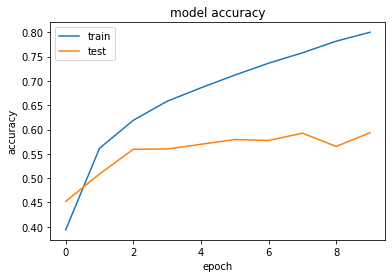

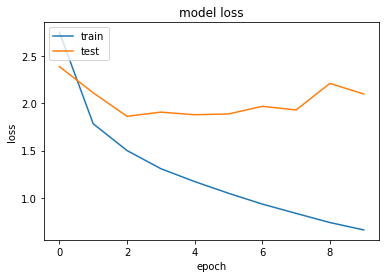

In [22]:
visualize(hist)

In [ ]:
fit_in_loop(model, le, start=1, epochs=3, need_report=False, dump_file='F:\\doodles\\mobilenet', fn_data_load=load_and_split)

### Примерно на 8 бакете произошел резкое падение точности на тестовой выборке почти до нуля. Изучив разные источники, возможной причиной может оказаться слишком высокий дропаут (По умолчанию он около 0.001, а я выставил на 0.4). Придется начать сначала умешнив значение.

### Попробовал еще раз с дефолтным дропаутом и то же самое. Возможно проблема в оптимизаторе или начальных весах.

In [ ]:
model = build_model(weights=None, dropout=None)

### Предобученные модели выдают странные результаты, не будем их настраивать, попробуем улучшить результат нашей модели - для этого улучшим показатели на "слабых" классах. Обучим еще одну модель, но теперь все "сильный" классы отнесем к одному классу

In [15]:
weak_classes = reports[-1][reports[-1]['f1-score'] < 0.6].index 
# weak_classes = ['asparagus', 'bear', 'bird', 'blackberry', 'blueberry', 'broom', 'camouflage', 'clarinet', 'cooler',
# 'crayon', 'dog', 'dragon', 'frog', 'hurricane', 'marker', 'matches', 'oven', 'pencil', 'pillow', 'pond',
#        'pool', 'raccoon', 'spreadsheet', 'squiggle', 'steak', 'tiger','toothpaste', 'trombone']
enc_weak_classes = dict([(cls, idx) for (idx, cls) in enumerate(weak_classes)])
enc_weak_classes['other'] = len(weak_classes)
enc_weak_classes

class WeakClassEncoder:
    def __init__(self, class_dict):
        self.dict=class_dict
        self.inversed = dict([(value,key) for key,value in class_dict.items()])
    
    def transform(self, series):
        return series.apply(lambda x: self.dict[x] if x in self.dict else self.dict['other'])
    
    def inverse_transform(self, encoded):
        return self.inversed[encoded] if encoded in self.inversed else None
    
weak_enc = WeakClassEncoder(enc_weak_classes)

In [17]:
X_train, X_test, y_train, y_test = load_data(0, weak_enc)

In [18]:
X_train.shape

(138761, 784)

In [19]:
tf.config.experimental.set_memory_growth(tf.config.get_visible_devices('GPU')[0], True)
DROP_OUT = 1
KERNEL_SIZE = 3
CATEGORIES = len(enc_weak_classes)

weak_model = keras.Sequential([
    keras.layers.Reshape((-1,28,28,1)),
    keras.layers.experimental.preprocessing.Rescaling(scale=1./255.),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
        
    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Flatten(),

    keras.layers.Dense(CATEGORIES * 10, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Dense(CATEGORIES * 30, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Dense(CATEGORIES * 30, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Dense(CATEGORIES, activation='softmax')
])
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipvalue=0.5)
weak_model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
weak_model.build(input_shape=(138761, 784))

In [21]:
weak_model.fit(X_train, y_train,
                             epochs=2,
                             batch_size=500,
                             validation_data=(X_test, y_test))

Epoch 1/2
278/278 [==============================] - 38s 117ms/step - loss: 1.4022 - accuracy: 0.7059 - val_loss: 0.7088 - val_accuracy: 0.9005
Epoch 2/2
278/278 [==============================] - 28s 101ms/step - loss: 0.5308 - accuracy: 0.8994 - val_loss: 0.5225 - val_accuracy: 0.9011


In [61]:
class EnsembleModel:
    def __init__(self, base_model, base_enc, additional_model, additional_enc, threshold=0.6):
        self.base_model = base_model
        self.base_enc = base_enc
        self.additional_model = additional_model
        self.additional_enc = additional_enc
        self.threshold = threshold
        
    def predict(self, X):
#         return X.apply(lambda series: self.__ensure_predictions(self.base_model.predict(X), X), axis=1)
        predicted = self.base_model.predict(X)
        result = np.array([np.argmax(x) for x in predicted], dtype=INT)
        for index, prediction in enumerate(predicted):
            result[index] = self.__ensure_prediction(prediction, X)
        return result
        
    
    def __ensure_predictions(self, probabilities, X):
        result = np.argmax(probabilities)
        if max(probabilities) < self.threshold:
            _class = np.argmax(self.additional_model.predict(X))
            _class_decoded = self.additional_enc.inverse_transform(_class)
            if _class_decoded is not None:
                result = self.base_enc.transform(_class_decoded)
        return result
    
    def __ensure_prediction(self, probability, X):
        result = np.argmax(probability)
        if max(probability) < self.threshold:
            
            _class = np.argmax(self.additional_model.predict(X))
            _class_decoded = self.additional_enc.inverse_transform(_class)
            if _class_decoded is not None:
                result = self.base_enc.transform(_class_decoded)
        return result
    
ens_model = EnsembleModel(model, le, weak_model, weak_enc)

In [40]:
val_X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173158 entries, 0 to 173157
Columns: 784 entries, 0 to 783
dtypes: int64(1), uint8(783)
memory usage: 130.6 MB


In [64]:
y_pred = ens_model.predict(val_X_test)

MemoryError: Unable to allocate 1.01 GiB for an array with shape (173158, 784) and data type int64

In [63]:
y_pred

array([ 56,  17,  99, 250,   3,  97,  49,  17, 251,  30, 197,  48, 208,
       107,  61, 190,  33,  12,  74, 232, 168, 203,   9, 183, 241,  66,
         3,  89, 235, 144,  44, 131, 109, 163,  80, 253,   3, 154,  48,
       141,  86, 128, 217, 120, 106, 161, 101,  86,  60, 169, 102, 179,
       140, 157,  40, 132, 216, 157, 129,  18, 128,  34,  12,  83,  19,
        75, 147,  50, 215, 236,  31, 125, 134, 245, 120,  52, 198, 129,
        10,  53, 115, 237, 153,  38, 167, 195, 168, 208,  10, 221,  52,
        91, 146, 149,  51, 131,  15, 143, 178,   1], dtype=uint8)